# Introduction

In the dynamic landscape of data science, Twitter has emerged as a crucial communication channel during times of crisis. The widespread use of smartphones empowers individuals to share real-time observations of emergencies, leading to increased interest from agencies in programmatically monitoring Twitter for disaster-related content, including relief organizations and news agencies. However, the challenge lies in determining whether a person's words genuinely indicate a disaster. Consider the example:

The author explicitly uses the word "ABLAZE" but means it metaphorically. While this may be clear to a human, it poses a unique challenge for machines.In this competition, your mission is to construct a machine learning model that distinguishes between tweets about real disasters and those that are not. You'll be equipped with a dataset of 10,000 tweets meticulously hand-classified for your exploration. If you're diving into NLP for the first time, fear not! We've crafted a quick tutorial to guide you swiftly into action.

# Explaratory Data Analysis and Cleanup

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import torch
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## 1.1 Distribution of Target Variable:

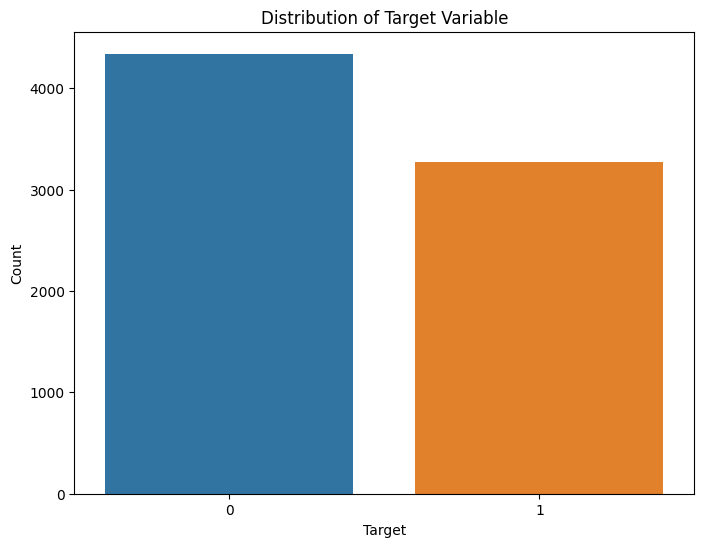

In [5]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

## 1.2 Missing Values Analysis:

In [6]:
# Check for missing values
missing_values = df_train.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [7]:
# Handle missing values in 'keyword' and 'location' columns (replace NaN with "")
df_train['keyword'].fillna("", inplace=True)
df_train['location'].fillna("", inplace=True)

# Create a new feature 'tweet_length' representing the length of each tweet
df_train['tweet_length'] = df_train['text'].apply(len)

# Check again for missing values
missing_values_after_handling = df_train.isnull().sum()
print("\nMissing Values After Handling:")
print(missing_values_after_handling)


Missing Values After Handling:
id              0
keyword         0
location        0
text            0
target          0
tweet_length    0
dtype: int64


## 1.3 Tweet Length Visualization:

In [8]:
# Create a new column for tweet length
df_train['tweet_length'] = df_train['text'].apply(len)

# Advanced Visualization: Interactive Histogram
fig = px.histogram(
    df_train,
    x='tweet_length',
    color='target',
    marginal='rug',
    nbins=100,
    labels={'tweet_length': 'Tweet Length'},
    title='Interactive Histogram of Tweet Lengths by Disaster and Non-Disaster Tweets',
    template='plotly_dark',  # Dark theme for better visualization
    opacity=0.8,
    barmode='overlay',  # Overlay histograms for comparison
)

fig.show()

## 1.4 Word Clouds:

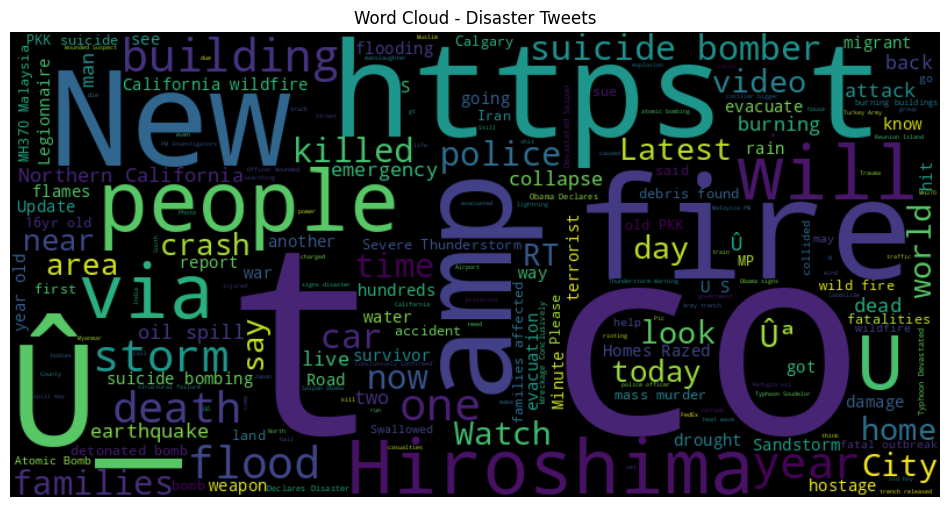

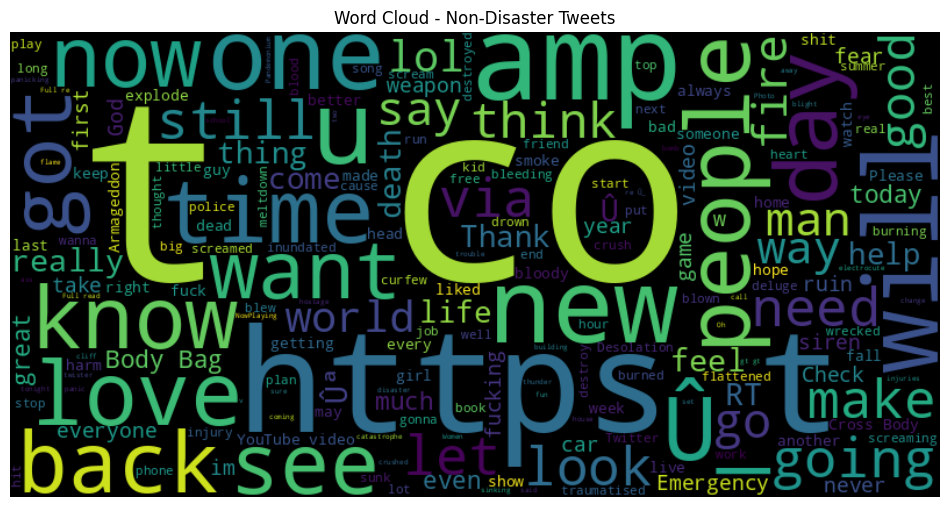

In [9]:
# Generate word clouds for disaster and non-disaster tweets
disaster_tweets = ' '.join(df_train[df_train['target'] == 1]['text'])
non_disaster_tweets = ' '.join(df_train[df_train['target'] == 0]['text'])

# Word cloud for disaster tweets
plt.figure(figsize=(12, 8))
wordcloud_disaster = WordCloud(width=800, height=400, background_color='black').generate(disaster_tweets)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets')
plt.axis('off')
plt.show()

# Word cloud for non-disaster tweets
plt.figure(figsize=(12, 8))
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='black').generate(non_disaster_tweets)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets')
plt.axis('off')
plt.show()

# 2. Data Cleaning :

## 2.1 Text Preprocessing:

In [10]:
# Download NLTK stopwords (if not already downloaded)
# import nltk
# nltk.download('stopwords')

# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

# Apply text preprocessing to the 'text' column
df_train['cleaned_text'] = df_train['text'].apply(preprocess_text)

In [11]:
df_train

,id,keyword,location,text,target,tweet_length,cleaned_text
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us
1,4,,,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,,,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,65,13 000 people receive wildfires evacuation ord...
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,83,two giant cranes holding bridge collapse nearb...
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,125,aria_ahrary thetawniest control wild fires cal...
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,m1 94 01 04 utc 5km volcano hawaii
7611,10872,,,Police investigating after an e-bike collided ...,1,137,police investigating bike collided car little ...


# 3. Feature Engineering :

## 3.1 Additional Text-Based Features:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



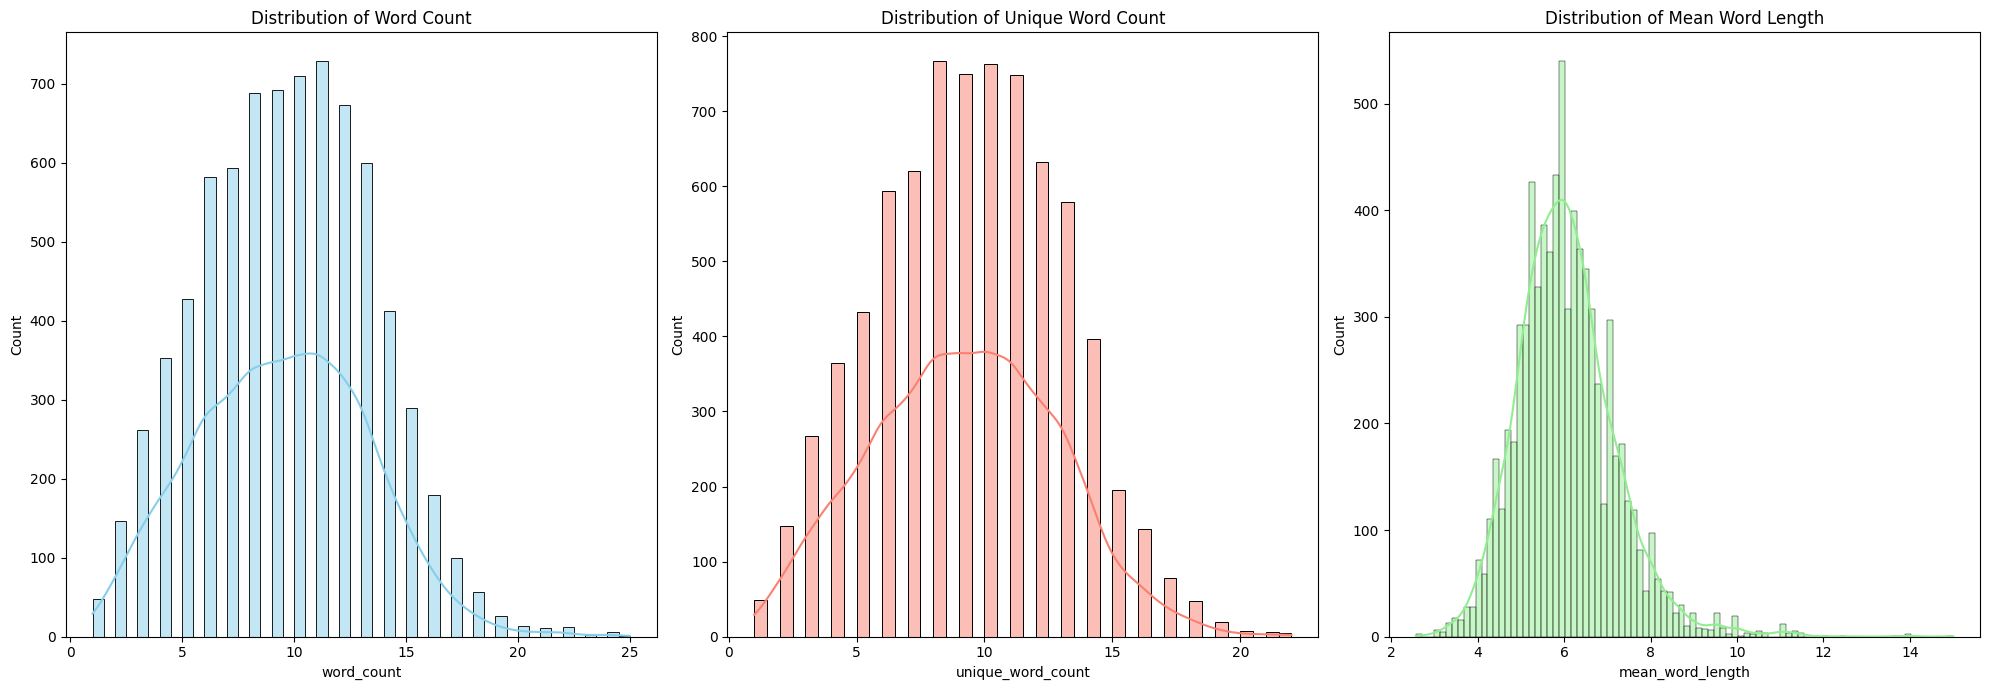

In [12]:
# Create features based on text analysis
df_train['word_count'] = df_train['cleaned_text'].apply(lambda x: len(str(x).split()))
df_train['unique_word_count'] = df_train['cleaned_text'].apply(lambda x: len(set(str(x).split())))
df_train['mean_word_length'] = df_train['cleaned_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

# Visualize the distributions of new features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

sns.histplot(df_train['word_count'], ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Word Count')

sns.histplot(df_train['unique_word_count'], ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Unique Word Count')

sns.histplot(df_train['mean_word_length'], ax=axes[2], color='lightgreen', kde=True)
axes[2].set_title('Distribution of Mean Word Length')

plt.tight_layout()
plt.show()

## 3.2 Keyword Encoding:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



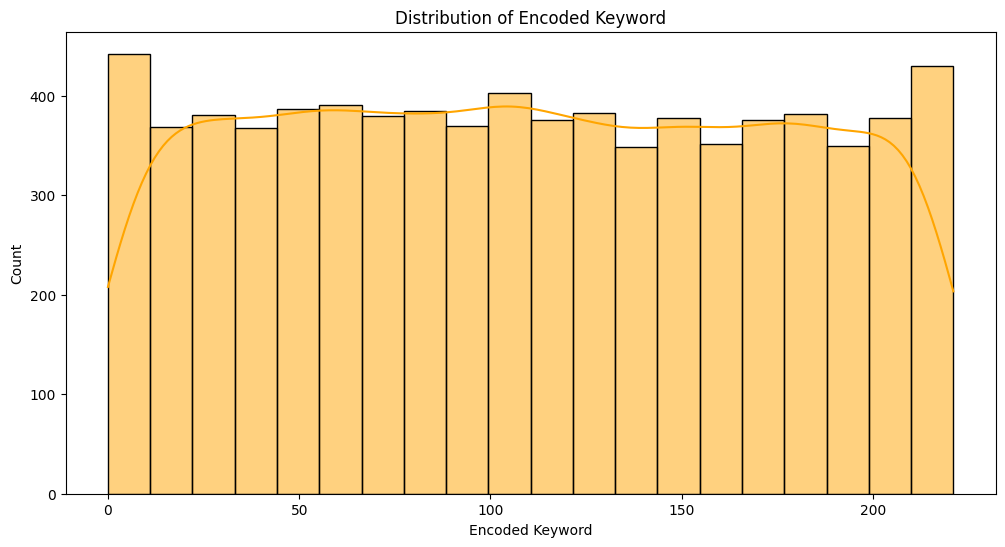

In [13]:
# Encode 'keyword' using Label Encoding
le = LabelEncoder()
df_train['keyword_encoded'] = le.fit_transform(df_train['keyword'])

# Visualize the distribution of the encoded keyword
plt.figure(figsize=(12, 6))
sns.histplot(df_train['keyword_encoded'], color='orange', kde=True)
plt.title('Distribution of Encoded Keyword')
plt.xlabel('Encoded Keyword')
plt.ylabel('Count')
plt.show()

# 4. Train-Test Split :

In [14]:
# from sklearn.model_selection import train_test_split

# # Define features (X) and target variable (y)
# X = df_train[['word_count', 'unique_word_count', 'mean_word_length', 'keyword_encoded', 'tweet_length','cleaned_text']]
# y = df_train['target']

# # Perform train-test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Display the shapes of the resulting sets
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

# 5. Text Vectorization :

In [15]:
# Define and fit the TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer(max_features=6090, stop_words='english', ngram_range=(1, 3))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])

# Apply text cleaning to the 'text' column in the test set
df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)

# Vectorize text in the test set using TF-IDF
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_text'])

In [16]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=6090, stop_words='english', ngram_range=(1, 3))

# Fit and transform the training text data
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])

# Transform the test text data
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_text'])

# Display the shapes of the resulting TF-IDF matrices
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (7613, 6090)
X_test_tfidf shape: (3263, 6090)


In [17]:
df_train

,id,keyword,location,text,target,tweet_length,cleaned_text,word_count,unique_word_count,mean_word_length,keyword_encoded
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us,7,7,5.428571,0
1,4,,,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,7,7,4.428571,0
2,5,,,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...,11,9,7.090909,0
3,6,,,"13,000 people receive #wildfires evacuation or...",1,65,13 000 people receive wildfires evacuation ord...,8,8,6.625000,0
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfires pou...,9,9,5.222222,0
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,83,two giant cranes holding bridge collapse nearb...,8,8,5.750000,0
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,125,aria_ahrary thetawniest control wild fires cal...,11,11,7.090909,0
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,m1 94 01 04 utc 5km volcano hawaii,8,8,3.375000,0
7611,10872,,,Police investigating after an e-bike collided ...,1,137,police investigating bike collided car little ...,15,14,6.533333,0


# 6. Model Building :

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Epoch 1/2 - Training Accuracy: 0.7695 - Validation Accuracy: 0.8313
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       874
           1       0.85      0.74      0.79       649

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.82      1523
weighted avg       0.83      0.83      0.83      1523

Epoch 2/2 - Training Accuracy: 0.8512 - Validation Accuracy: 0.8398
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.81      0.94      0.87       874
           1       0.90      0.71      0.79       649

    accuracy                           0.84      1523
   macro avg       0.85      0.82      0.83      1523
weighted avg       0.85      0.84      0.84      1523



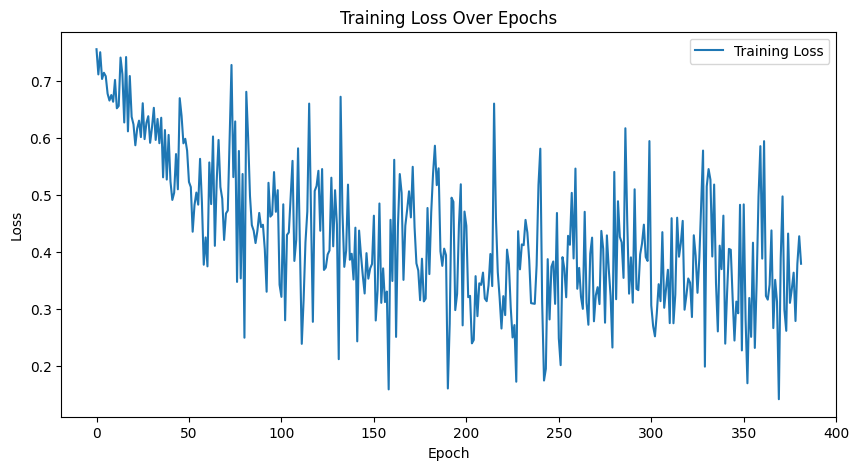

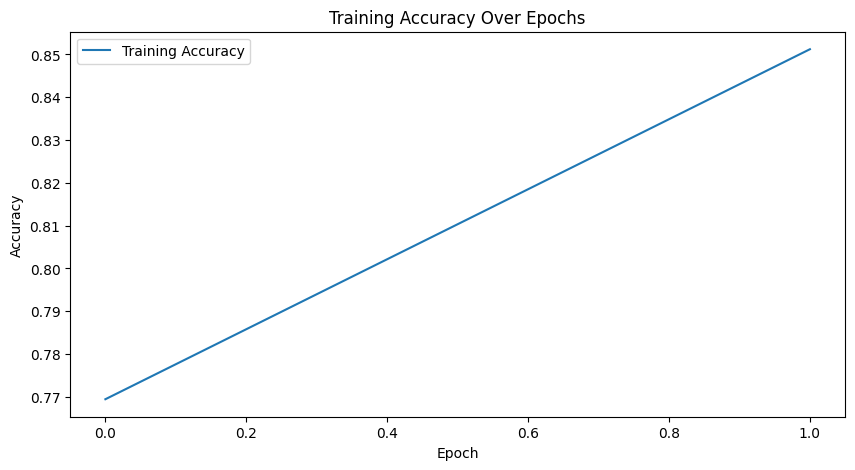

In [18]:
# Define BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Split the training set into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    df_train[['word_count', 'unique_word_count', 'mean_word_length', 'keyword_encoded', 'tweet_length','cleaned_text']],
    df_train['target'],
    test_size=0.2,
    random_state=42
)

# Create DataLoader for training and validation sets
encoded_data_train = tokenizer.batch_encode_plus(
    X_train['cleaned_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val['cleaned_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

dataset_train = TensorDataset(
    encoded_data_train['input_ids'],
    encoded_data_train['attention_mask'],
    torch.tensor(y_train.tolist())
)

dataset_val = TensorDataset(
    encoded_data_val['input_ids'],
    encoded_data_val['attention_mask'],
    torch.tensor(y_val.tolist())
)

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=32)
dataloader_val = DataLoader(dataset_val, batch_size=32)

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop (fine-tuning the BERT model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 2

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
test_accuracies = []
test_losses = []


# Define a function to evaluate the model on the test set
def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []  # Add this line to collect labels

    for batch in dataloader:
        input_ids, attention_mask, *labels = batch  # Adjust unpacking to handle cases with and without labels
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        all_predictions.extend(predictions)

        if labels:
            all_labels.extend(labels[0].tolist())  # Append labels if present

    return all_predictions, all_labels


# Training loop
for epoch in range(epochs):
    model.train()
    all_predictions_train = []
    all_labels_train = []

    for batch in dataloader_train:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        logits_train = outputs.logits
        predictions_train = torch.argmax(logits_train, dim=1).tolist()
        all_predictions_train.extend(predictions_train)
        all_labels_train.extend(labels.tolist())

    train_accuracy = accuracy_score(all_labels_train, all_predictions_train)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    model.eval()
    
    all_predictions_val, all_labels_val = evaluate_model(model, dataloader_val, device)

    accuracy_val = accuracy_score(all_labels_val, all_predictions_val)
    classification_rep_val = classification_report(all_labels_val, all_predictions_val)
    print(f"Epoch {epoch + 1}/{epochs} - Training Accuracy: {train_accuracy:.4f} - Validation Accuracy: {accuracy_val:.4f}")
    print("Classification Report (Validation):\n", classification_rep_val)

    valid_accuracies.append(accuracy_val)
    valid_losses.append(1 - accuracy_val)  # Store validation error for plotting

    
# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 7. Prediction on Test Set :

In [19]:
# Set up the test dataloader
encoded_data_test = tokenizer.batch_encode_plus(
    df_test['cleaned_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

dataset_test = TensorDataset(
    encoded_data_test['input_ids'],
    encoded_data_test['attention_mask']
)

dataloader_test = DataLoader(dataset_test, batch_size=32)


# Evaluate on the test set
model.eval()
all_predictions_test = []

for batch in dataloader_test:
    input_ids, attention_mask = batch
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions_test = torch.argmax(logits, dim=1).tolist()
    all_predictions_test.extend(predictions_test)

# Create a submission DataFrame with the predicted labels
submission_df = pd.DataFrame({'id': df_test['id'], 'target': all_predictions_test})

# Reorder the columns to have 'id' as the first column
submission_df = submission_df[['id', 'target']]

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission DataFrame
submission_df

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


# Conclusion

In conclusion, this competition challenges us to create a smart computer program that can understand whether a tweet is really talking about a disaster or not. With Twitter being a key source of information during emergencies, the need for accurate detection is crucial. We've been given a dataset of 10,000 tweets to work with, and even if you're new to this, there's a helpful tutorial to guide you. Remember, the task might be tricky, as words can have different meanings. So, let's dive in, learn, and create a helpful tool for identifying real disaster-related tweets in the vast world of social media.

Good luck, and let's make a positive impact!